## Predicting Medical Expenses Using Linear Regression

#### QUESTION

ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.

You're given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.

In [1]:
# # Downloading the data
from urllib.request import urlretrieve
csv_data_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

urlretrieve(csv_data_url, 'medical_charges.csv')

('medical_charges.csv', <http.client.HTTPMessage at 0x7fa4f8242450>)

In [2]:
import numpy as np
import pandas as pd
medical_df = pd.read_csv('medical_charges.csv')
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Our objective is to find a way to estimate the value in 'charges' columns using the values in other columns. If we can do so for the historical data, then we should be able to estimate charges for new customers too.

In [3]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None of the columns contain missing values.

In [4]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
import plotly.express as px

In [6]:
# To render non interactive charts
import plotly.io as pio
pio.renderers.default = 'png'

To improve the default style and font sizes of our chart

In [7]:
px.defaults.height = 576
px.defaults.width = 1024

#### Age

The minimum age in dataset is 18 and the maximum is 64. Thus we can visualize the distribution of age in 64-16, 47 bins (one for 1 year) and a box plot.

In [8]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

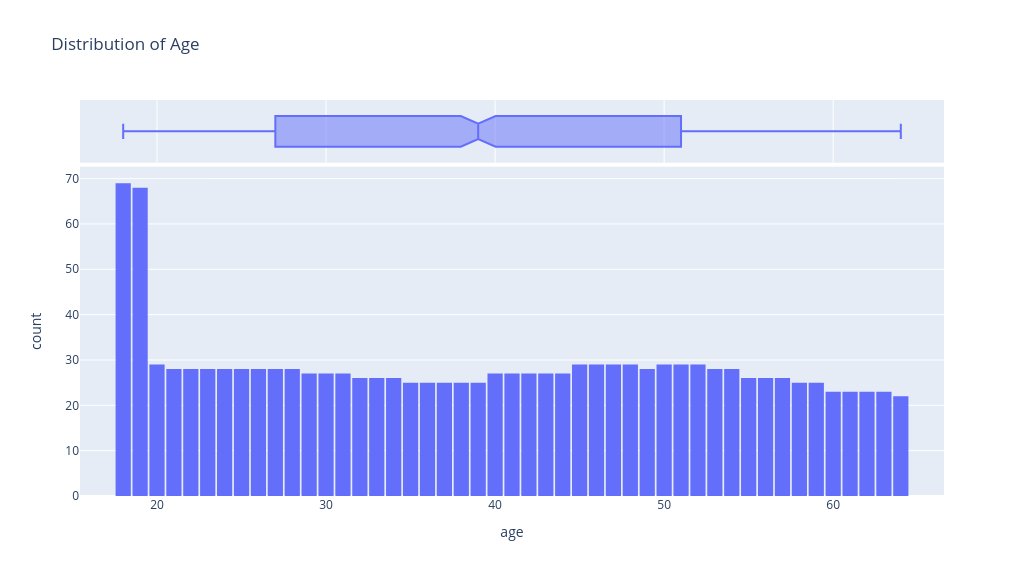

In [9]:
fig = px.histogram(
    medical_df, x='age', marginal='box', nbins=47, title='Distribution of Age'
)
fig.update_layout(bargap=0.1)
fig.show()

The uniform distribution (except ages 18 and 19) might arise from the fact that there isn't a big variation in the number of people of any given age in the USA.

#### BMI

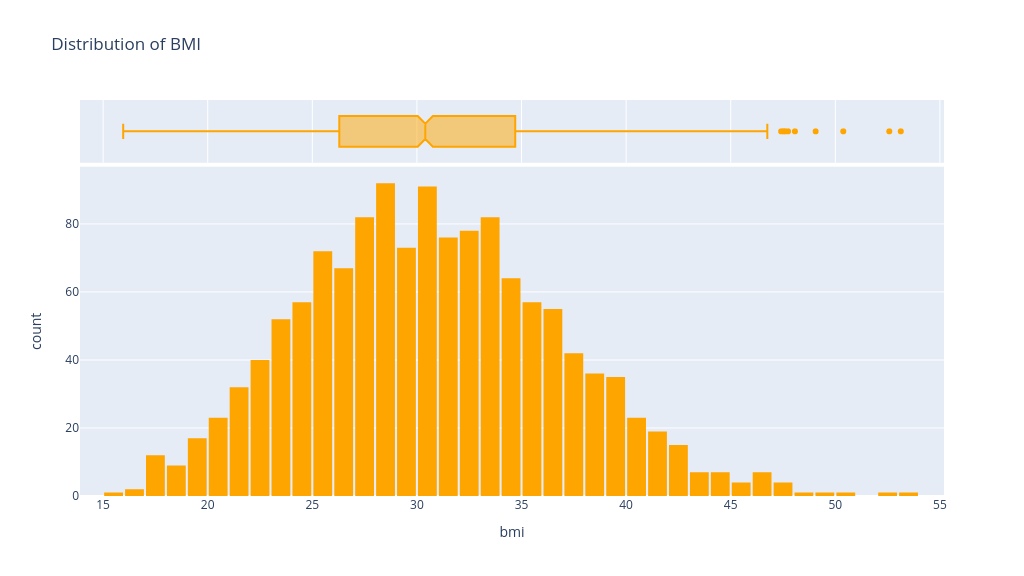

In [10]:
fig = px.histogram(
    medical_df, x='bmi', marginal='box', color_discrete_sequence=['orange'],title='Distribution of BMI'
)
fig.update_layout(bargap=0.1)
fig.show()

Them measurements of BMI seem to form a Gaussian distribution centered around the value 30, with a few outliers towards right.

#### Charges

This is the column we are trying to predict. Let's also use the categorical column 'smoker' to distinguish the charges for smokers and non-smokers.

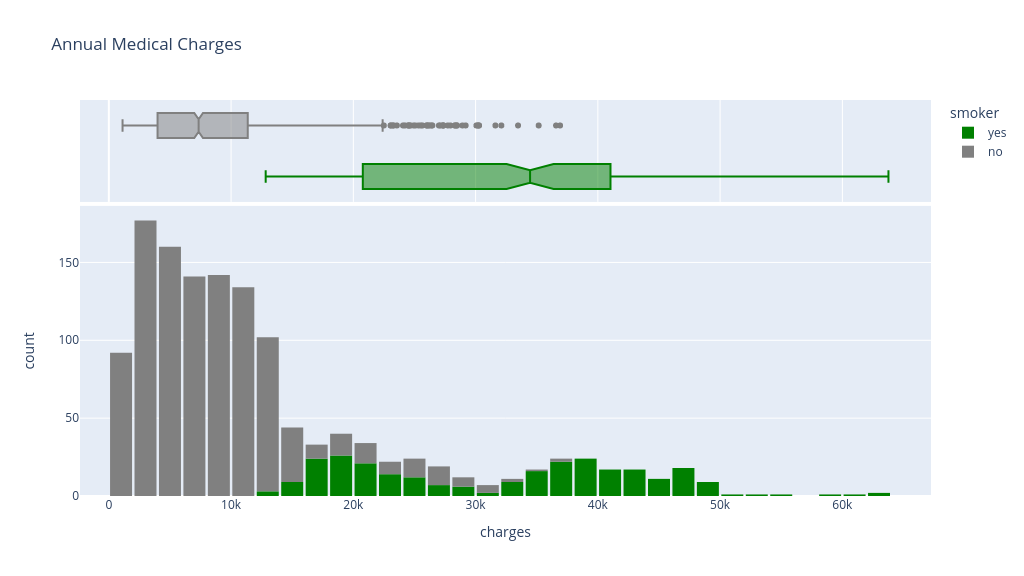

In [11]:
fig = px.histogram(
    medical_df, x='charges', marginal='box',
    color_discrete_sequence=['green', 'grey'],
    title='Annual Medical Charges',
    color='smoker'
)
fig.update_layout(bargap=0.1)
fig.show()

- The distribution follows a power law.
- There is significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is 7300$, the median for smokers is close to 35000$.

#### Smoker

In [12]:
medical_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

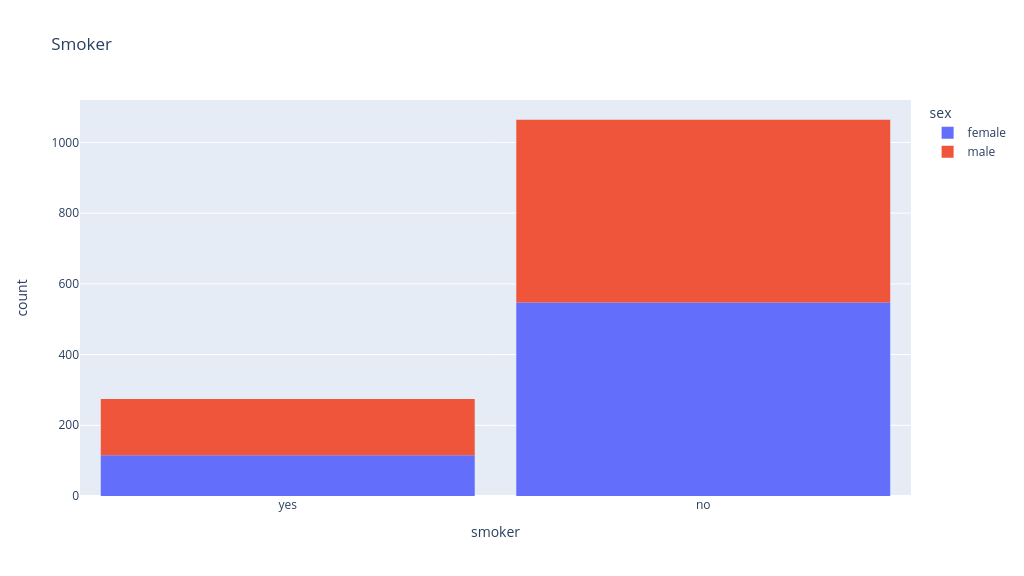

In [13]:
fig = px.histogram(
    medical_df, x='smoker', title='Smoker', color='sex'
)
fig.update_layout(bargap=0.1)
fig.show()

Make sure distributions of each column matches the distribution of the population. For example if we have 90% smokers and the poplation have only 10% smokers any model we build on the 90% smoker input data will fail.

#### Age and Charges

Let's visualize the relation between 'age' and 'charges' using a scatter plot. Each point in the scatter plot represents one customer (row). We'll also use values in ther 'smoker' column to color the points.

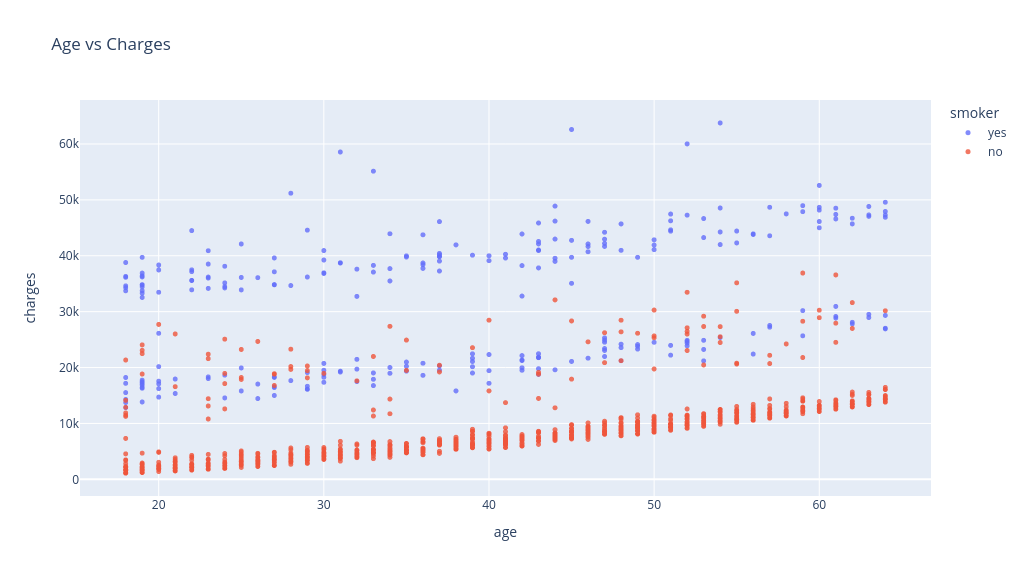

In [14]:
fig = px.scatter(
    medical_df, x='age', y='charges', color='smoker', opacity=0.8,
    hover_data=['sex'], title='Age vs Charges'
)
fig.update_traces(marker_size=5)
fig.show()

- The general trend seems to be that the medical charges increase with age.
- We can see 3 'clusters' of points, each of which seems to form a line with an increasing slope:
    - First cluster consists of healthy non-smokers who have relatively low medical charges.
    - Second cluster contains a mix of smokers and non-smokers. It is possible that these are two distinct but overlapping clusters: 'non-smokers with medical issues' and 'smokers without any major issues'.
    - Final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.


#### BMI and Charges

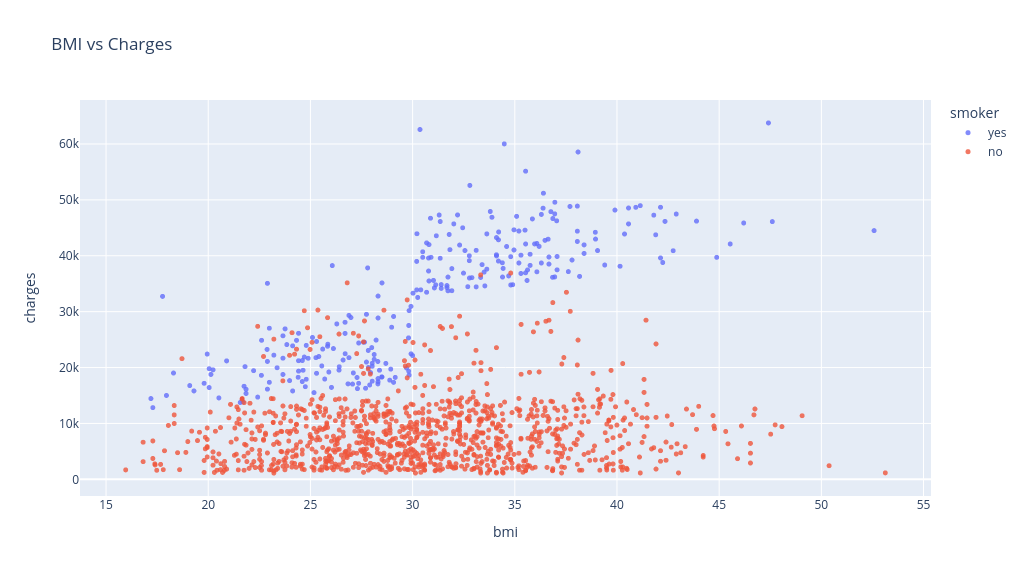

In [15]:
fig = px.scatter(
    medical_df, x='bmi', y='charges', color='smoker', opacity=0.8,
    hover_data=['sex'], title='BMI vs Charges'
)
fig.update_traces(marker_size=5)
fig.show()

#### Smoker and Charges

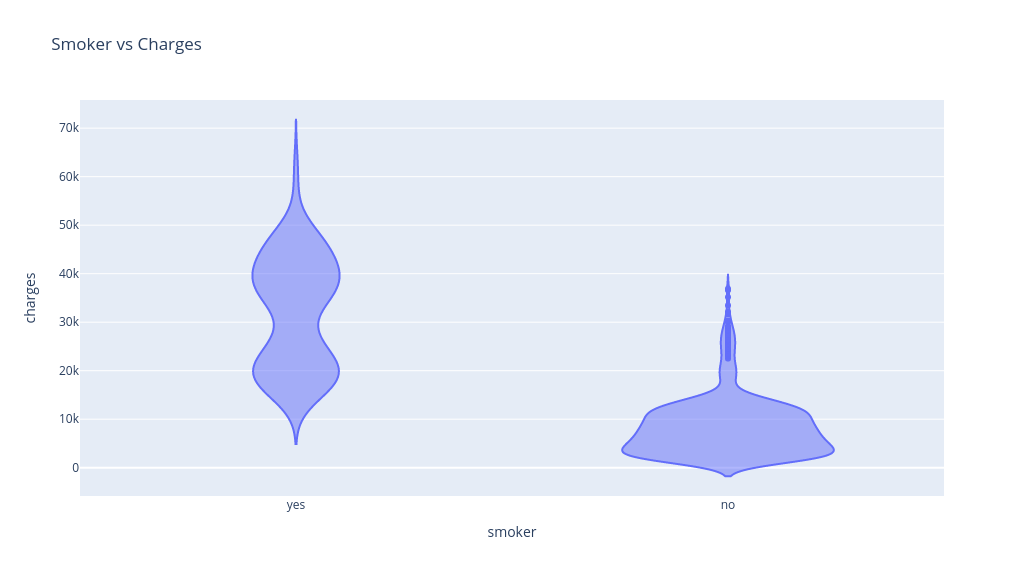

In [16]:
fig = px.violin(
    medical_df, x='smoker', y='charges', title='Smoker vs Charges'
)
fig.show()

For non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seems to be significantly higher for smokers with a BMI greater than 30.

#### Correlation

The values in some columns are closely related to the values in 'charges' compared to other columns. This relationship is often expressed numerically using a measure called correlation coefficient, which can be computed using .corr method of pandas series.

In [17]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

To compute correlation for categorical columns, they must first be converted into numeric columns.

In [18]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.7872514304984767

Stregth and direction of relationship can be interpreted from correlation coefficient.

In [19]:
medical_df.corr(numeric_only=True)

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


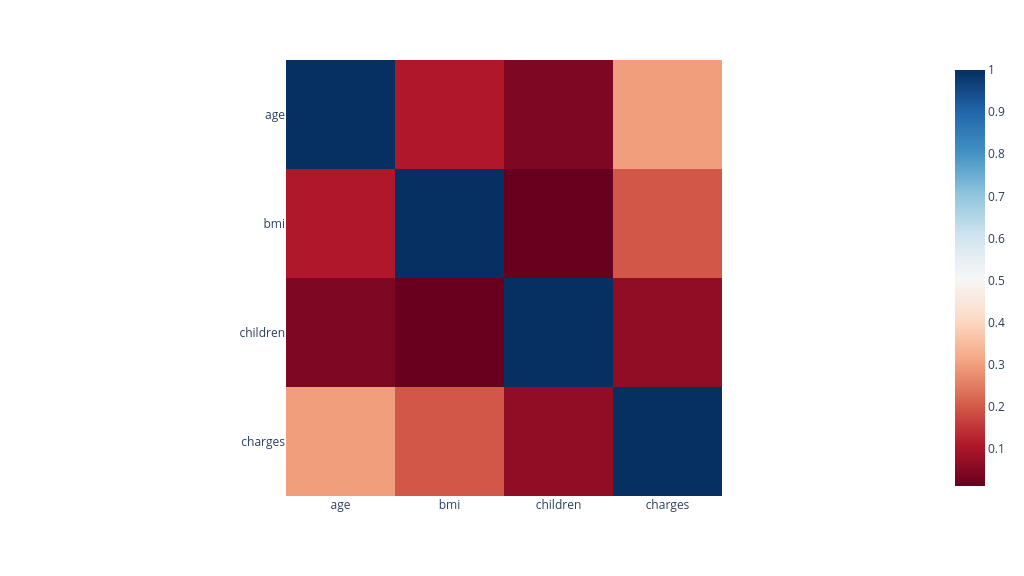

In [20]:
px.imshow(
    medical_df.corr(numeric_only=True),
    color_continuous_scale='RdBu'
)

Correlation vs Causation fallasy

A high correlation cannot be used to interpret a cause-effect relationship between featues.

### Single Feature Linear Regression

We now know that the 'smoker' and 'age' columns have the strongest correlation with 'charges'. Let's try to find a way of estimating the value of 'charges' using the value of 'ages' for non-smokers.

In [21]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

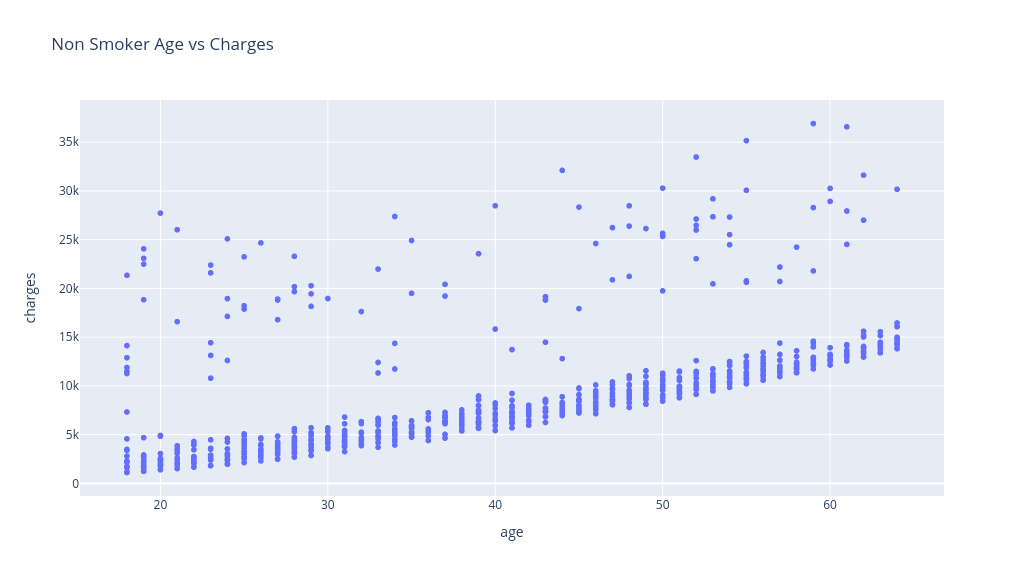

In [22]:
# sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15)
px.scatter(
    non_smoker_df, x='age', y='charges', title='Non Smoker Age vs Charges'
)

Apart from few exceptions the points seem to form a line. We'll try and fit a line using this points, and use the line to predict charges for a given age.

The line is characterized two numbers w(called 'slope') and b(called 'intercept').

y = wx + c

charges = w x age + c

Now we try to determine w and c for the line that best fits the data.

- This technique is called linear regression and we call the above equation a linear regression model.
- The numbers w and b are called parameters or weights of the model.
- The values in the 'age' column are called inputs and the values in the 'charges' column are called targets.

Let's define a helper function estimate_charges to compute charges

In [23]:
def estimate_charges(age, w, b):
    return w * age + b
# Assuming w and b
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, 50, 100)
estimated_charges

1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64

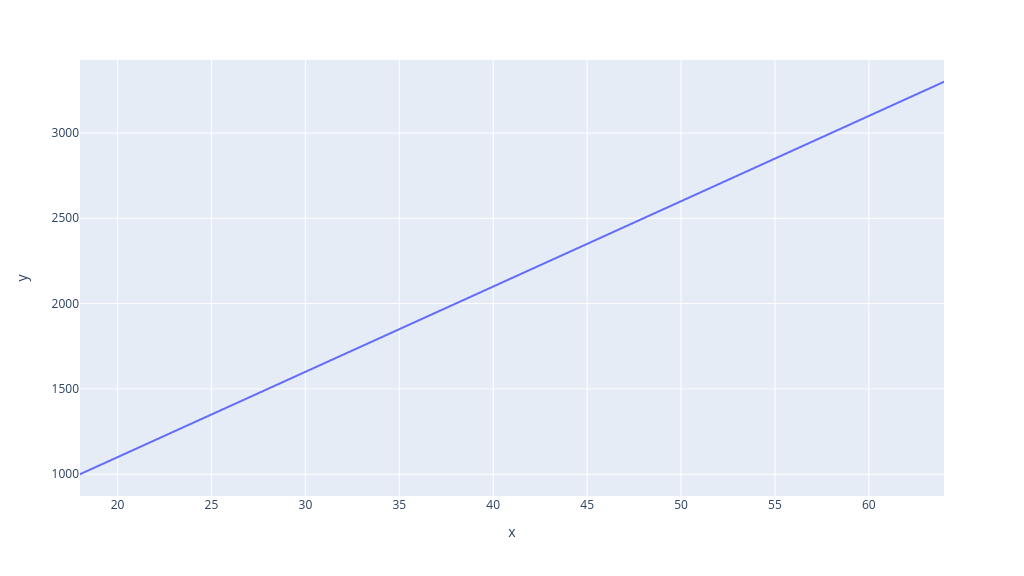

In [24]:
# Plotting the estimated charges
fig = px.line(x=ages, y=estimated_charges)
fig.show()

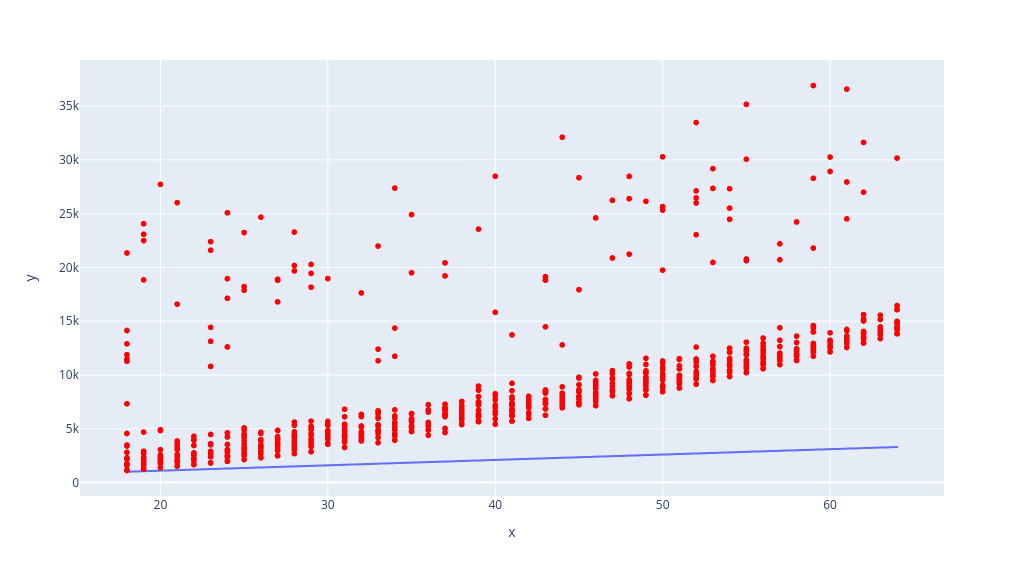

In [25]:
# Now we plot our actual data over this
fig.add_trace(
    px.scatter(
        x=ages, y=non_smoker_df.charges, color_discrete_sequence=['red']
    ).data[0]
    )

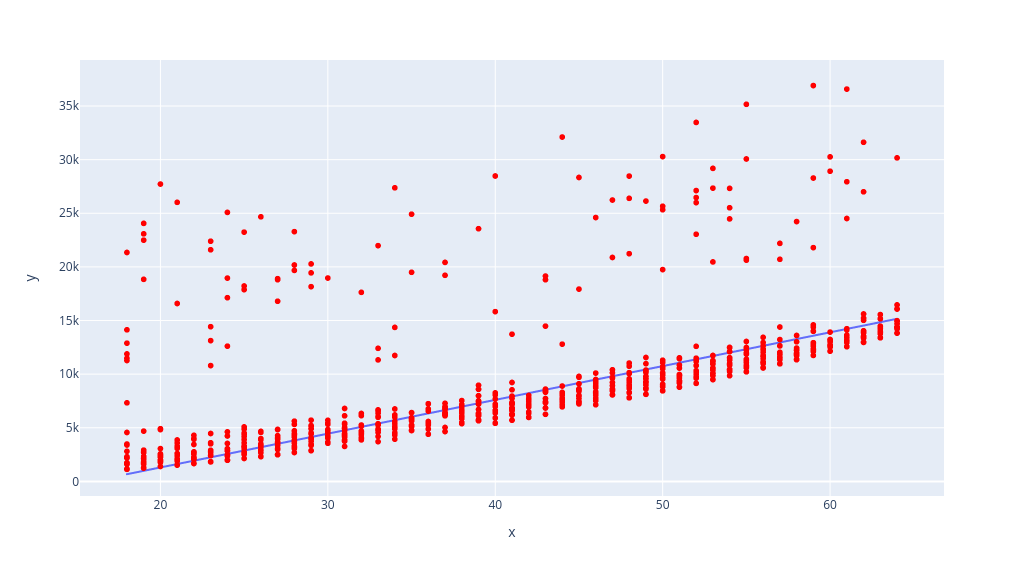

In [26]:
# Helper function to adjust the line manually
def try_parameters(non_smoker_df, w, b):
    ages = non_smoker_df.age
    charges = non_smoker_df.charges
    estimated_charges = estimate_charges(ages, w, b)
    fig = px.line(x=ages, y=estimated_charges)
    fig.add_trace(
        px.scatter(
            x=ages, y=charges, color_discrete_sequence=['red']
        ).data[0]
    )
    fig.show()
try_parameters(non_smoker_df, 315, -5000)

#### Loss/Cost Function

We can compare our model's predictions with the actual targets using 'root mean square error'.

RMSE = $\sqrt{\sum_{i=1}^{n} (Predicted_i - Actual_i)^2 / n}$



In [27]:
targets = non_smoker_df.charges
predictions = estimate_charges(non_smoker_df.age, 315, -5000)

In [28]:
def rmse(target, prediction):
    return np.sqrt(np.mean(np.square(target - prediction)))
rmse(targets, predictions)

4821.549525592373

On average, each element in the prediction differs from the actual target by $4822. The result is called the loss because it indicates how bad the model is at predicting the target variables.